# Conformer Search

In this notebook, we use the ORCA Python Interface (OPI) to perform a conformer search with a force field. Since the resulting energy ranking may lack accuracy, we re-rank the conformers using DFT single point energy calculations. We will first demonstrate how this can be done with RDKit and afterwards wih GOAT.

Workflow:
1. Import required Python dependencies.
2. Define a working directory.
3. Define an input structure via SMILES
4. Generate conformers with RDKit.
5. perform DFT single point calculations for re-ranking.
6. Visualize the resulting conformer ensemble.
7. Generate conformers using GOAT via OPI and re-rank them.

## Step 1: Import Dependencies

We start by importing the modules needed for:
- Interfacing with ORCA input/output
- RDKit
- Numerical calculations and data handling
- Plotting results

> **Note:** We additionally import modules for visualization/plotting like `py3Dmol`. For this, it might be necessary to install `py3Dmol` into your OPI `venv` (e.g., by activating the `.venv` and using `uv pip install py3Dmol`).

In [1]:
import re
import copy
import shutil
from pathlib import Path

# RDKit as conformer generator
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolAlign
from rdkit.Chem.rdchem import Mol

# OPI imports for performing ORCA calculations and reading output
from opi.core import Calculator
from opi.input.structures.structure import Structure
from opi.input.simple_keywords import BasisSet, Dft, ForceField, Scf
from opi.input.simple_keywords.goat import Goat

# for plotting results and visualization of molecules
import py3Dmol
import pandas as pd
import matplotlib.pyplot as plt

## Step 2: Working Directory and Conversion Factor

We define a subfolder `RUN` in which the actual ORCA calculations will take place. Also, we define a conversion factor, since we want the resulting interaction energies in kcal/mol for better interpretability.

In [ ]:
# > Calculation is performed in `RUN`
working_dir = Path("RUN")
# > The `working_dir`is automatically (re-)created
shutil.rmtree(working_dir, ignore_errors=True)
working_dir.mkdir()
# > Conversion factor for atomic units to kcal/mol
unit_conversion = 627.509 

## Step 3: Define an Input Structure via SMILES

We define the input structure as a smiles string and load the smiles string to an RDKit Mol. Then we visualize the 2D structure. After that we add hydrogen atoms and identify the chiral center. 

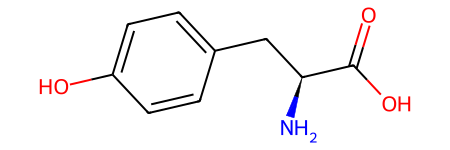

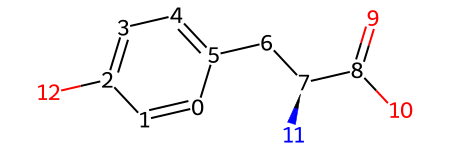

Chiral centers identified: [(7, 'S')]


In [3]:
input_smiles='C1=CC(=CC=C1C[C@@H](C(=O)O)N)O'
# Convert SMILES to RDKit Mol and label atoms for visualization
mol = Chem.MolFromSmiles(input_smiles)
display(mol)
for atom in mol.GetAtoms():
    atom.SetProp('atomLabel', str(atom.GetIdx()))
display(mol)

# Add hydrogens and identify chiral centers
mol = Chem.AddHs(mol)
chiral_centers = Chem.FindMolChiralCenters(mol)
if chiral_centers:
    print('Chiral centers identified:', chiral_centers)

## Step 4: Conformer Generation with RDKit
Conformer ensembles do not have to be generated with OPI. They can come from various sources. Here, we use the conformers generated by RDKit:

In [4]:
def confGenerator_RDKit(smiles: str, e_thresh: float, confs: int, 
                        rms: float, method: str) -> tuple[list[tuple[float, int]], Mol, str]:
    """Generate and optimize conformers using RDKit"""
    
    # Generate 3D conformers
    conformer_ids = AllChem.EmbedMultipleConfs(
        mol,
        numConfs=confs,
        pruneRmsThresh=rms,
        randomSeed=1,
        useExpTorsionAnglePrefs=True,
        useBasicKnowledge=True
    )
    print('Number of raw conformers:', len(conformer_ids))

    # Optimization for each conformer
    mmff_props = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant=method)
    conformer_energies = []
    for conf_id in conformer_ids:
        ff = AllChem.MMFFGetMoleculeForceField(mol, mmff_props, confId=conf_id)
        ff.Minimize()
        energy_value = float(ff.CalcEnergy())
        conformer_energies.append((energy_value, conf_id))

    # Sort by energy and filter below energy threshold
    conformer_energies.sort()
    min_energy = conformer_energies[0][0]

    filtered_mol = copy.deepcopy(mol)
    filtered_mol.RemoveAllConformers()
    selected_conf_ids = []
    filtered_rel_e = []

    data = []
    for idx, (energy_value, conf_id) in enumerate(conformer_energies, start=1):
        delta_e = energy_value - min_energy
        status = "below" if delta_e <= e_thresh else "above"
        data.append({
            "ConfID": conf_id,
            "Energy (kcal/mol)": f"{energy_value:.2f}",
            "ΔE (kcal/mol)": f"{delta_e:.2f}",
            "Status": status
        })
        if delta_e <= e_thresh:
            conf = mol.GetConformer(conf_id)
            filtered_mol.AddConformer(conf)
            selected_conf_ids.append(conf_id)
            filtered_rel_e.append((delta_e, conf_id))

    df = pd.DataFrame(data)
    print(f"\nNumber of conformers below {e_thresh} kcal/mol ({method}): {len(selected_conf_ids)}")
    display(df.style.hide(axis="index"))
    return filtered_rel_e, filtered_mol, method

# > Run RDKit conformer search
filtered_rel_e_rdkit, filtered_mol_rdkit, method_rdkit = confGenerator_RDKit(smiles=input_smiles, e_thresh=1.5, confs=60, rms=0.02, method='MMFF94s')


Number of raw conformers: 59

Number of conformers below 1.5 kcal/mol (MMFF94s): 16


ConfID,Energy (kcal/mol),ΔE (kcal/mol),Status
20,39.25,0.00,below
23,39.28,0.03,below
21,39.83,0.59,below
45,40.10,0.85,below
51,40.27,1.02,below
40,40.34,1.09,below
31,40.34,1.09,below
44,40.34,1.09,below
4,40.34,1.09,below
55,40.34,1.09,below


## Step 5: DFT Single Point Energy Calculations

To re-rank the generated conformers we can employ OPI for DFT single&ndash;point energy calculations. In the functions below this is done with the composite DFT method r²SCAN-3c. The re-ranking is directly visualized with matplotlib. The energy window for performing DFT calculations is set smaller than necessary for prdouction runs to keep the computational costs of this notebook low.


Running DFT calculations with ORCA...
Conformer 20: DFT Energy = -629.909388 Eh
Conformer 23: DFT Energy = -629.909430 Eh
Conformer 21: DFT Energy = -629.905355 Eh
Conformer 45: DFT Energy = -629.910666 Eh
Conformer 51: DFT Energy = -629.911539 Eh
Conformer 40: DFT Energy = -629.908164 Eh
Conformer 31: DFT Energy = -629.904879 Eh
Conformer 44: DFT Energy = -629.904873 Eh
Conformer 4: DFT Energy = -629.904860 Eh
Conformer 55: DFT Energy = -629.904893 Eh
Conformer 16: DFT Energy = -629.904873 Eh
Conformer 9: DFT Energy = -629.904857 Eh
Conformer 56: DFT Energy = -629.903863 Eh
Conformer 0: DFT Energy = -629.903859 Eh
Conformer 1: DFT Energy = -629.903840 Eh
Conformer 46: DFT Energy = -629.908024 Eh


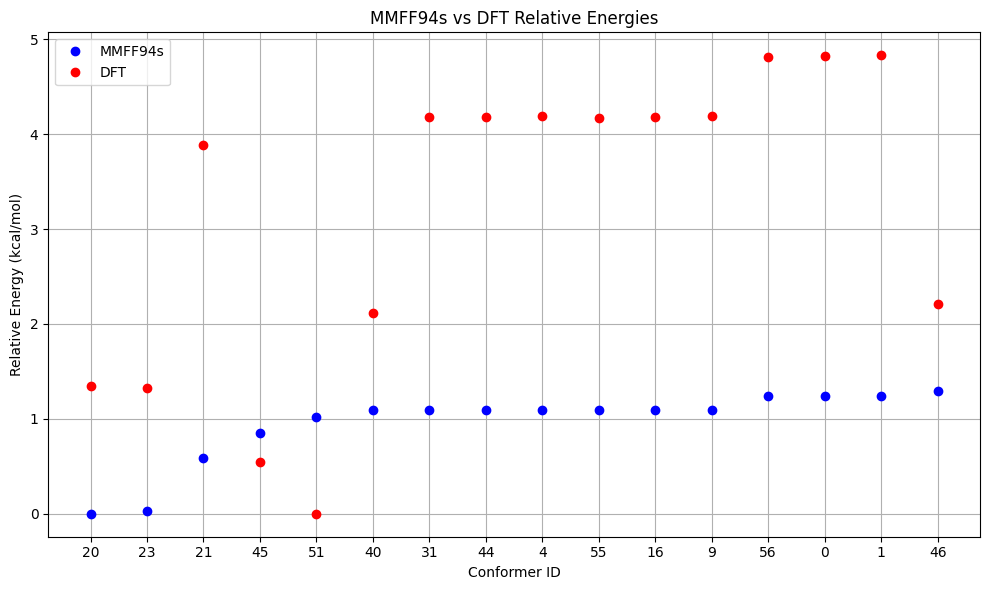


Energy Comparison Table:


ConfID,MMFF94s (kcal/mol),DFT (kcal/mol),Rank Change
20,0.00,1.35,↓3
23,0.03,1.32,↓1
21,0.59,3.88,↓4
45,0.85,0.55,↑2
51,1.02,0.00,↑4
40,1.09,2.12,↑1
31,1.09,4.18,↓2
44,1.09,4.18,↓2
4,1.09,4.19,↓3
55,1.09,4.17,↑2



Number of conformers below 1.0 kcal/mol (DFT): 2


ConfID,DFT Energy (Eh),ΔE (kcal/mol),Status
51,-629.911539,0.00,below
45,-629.910666,0.55,below
23,-629.909430,1.32,above
20,-629.909388,1.35,above
40,-629.908164,2.12,above
46,-629.908024,2.21,above
21,-629.905355,3.88,above
55,-629.904893,4.17,above
31,-629.904879,4.18,above
44,-629.904873,4.18,above


In [5]:
def dft_calculations(smiles: str, e_thresh: float, functional: Dft, basis: BasisSet | None, 
                     rel_e: list[tuple[float, int]], mol: Mol, method: str, working_dir: Path = Path("RUN")) -> tuple[Mol, list[int]]:
    """Perform DFT single point energy calculations using ORCA"""
    smiles = re.sub(r'[^A-Za-z0-9]', '_', smiles)
    smiles_dir = working_dir / f"{smiles}_{method}"
    smiles_dir.mkdir(exist_ok=True)
    
    dft_energies = []
    comparison = []
    print("\nRunning DFT calculations with ORCA...")

    for delta_e, cid in rel_e:
        
        xyz_file = smiles_dir / f"conf_{cid}.xyz"
        xyz_block = Chem.MolToXYZBlock(mol, confId=cid)

        with open(xyz_file, 'w') as f:
            f.write(xyz_block)

        # > Set up the structure
        xyz_file = Path(xyz_file)
        mol_name = xyz_file.stem
        structure = Structure.from_xyz(xyz_file)

        # > Define a directory for calculation files
        calc_dir = xyz_file.parent / mol_name
        calc_dir.mkdir(exist_ok=True)

        # > Set up the calculator
        calc = Calculator(basename=mol_name, working_dir=calc_dir)
        calc.structure = structure
        # > Neutral structure
        calc.structure.charge = 0
        # > Spin multiplicity of 1 (closed-shell)
        calc.structure.multiplicity = 1
        # Some methods like r²SCAN-3c have their own predefined basis set
        if basis:
            calc.input.add_simple_keywords(functional, basis, Scf.NOAUTOSTART)
        else:
            calc.input.add_simple_keywords(functional, Scf.NOAUTOSTART)
        
        # > Run the calculation on 4 cores
        calc.input.ncores = 4

        # > Write ORCA input file
        calc.write_input()
        
        # > Run the calculation
        calc.run()
        
        # > Get and check the output
        output = calc.get_output()
        # > Check for proper termination of ORCA
        status = output.terminated_normally()
        if not status:
            # > ORCA did not terminate normally
            raise RuntimeError(f"ORCA did not terminate normally, see output file: {output.get_outfile()}")
        else:
            # > ORCA did terminate normally so we can parse the output
            output.parse()

        # > Now check for convergence of the SCF
        if not output.results_properties.geometries[0].single_point_data.converged:
            raise RuntimeError("SCF DID NOT CONVERGE")
        
        # > Obtain the energy from the DFT calculation
        e_dft = output.results_properties.geometries[0].single_point_data.finalenergy
        
        dft_energies.append((e_dft, cid))
        comparison.append({
            'Conformer': cid,
            f'{method} (kcal/mol)': delta_e,                
            'DFT (kcal/mol)': 0
        })
        print(f"Conformer {cid}: DFT Energy = {e_dft:.6f} Eh")

    # Calculate relative DFT energies
    dft_energies.sort()
    min_dft = dft_energies[0][0]

    for entry in comparison:
        cid = entry['Conformer']
        for e_dft, dft_id in dft_energies:
            if cid == dft_id:
                entry['DFT (kcal/mol)'] = (e_dft - min_dft) * unit_conversion
                break

    df_dft = pd.DataFrame(comparison).sort_values(f'{method} (kcal/mol)')
    
    # Plot energies differences
    x_vals = range(len(df_dft))
    conformer_ids = df_dft['Conformer']

    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, df_dft[f'{method} (kcal/mol)'], 'bo', label=f'{method}')
    plt.plot(x_vals, df_dft['DFT (kcal/mol)'], 'ro', label='DFT')
    plt.xticks(x_vals, conformer_ids)
    plt.xlabel('Conformer ID')
    plt.ylabel('Relative Energy (kcal/mol)')
    plt.title(f'{method} vs DFT Relative Energies')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Compare conformer ranks by FF vs DFT energy
    print("\nEnergy Comparison Table:")
    method_rank = df_dft.sort_values(f'{method} (kcal/mol)')['Conformer'].tolist()
    dft_rank = df_dft.sort_values('DFT (kcal/mol)')['Conformer'].tolist()

    comparison_table = []
    for _, row in df_dft.iterrows():
        cid = row['Conformer']
        method_r = method_rank.index(cid) + 1
        dft_r = dft_rank.index(cid) + 1
        delta = method_r - dft_r
        mark = f"{'↑' if delta > 0 else '↓' if delta < 0 else '='}{abs(delta)}" if delta else "-"

        comparison_table.append({
            "ConfID": int(cid),
            f"{method} (kcal/mol)": f"{row[f'{method} (kcal/mol)']:.2f}",
            "DFT (kcal/mol)": f"{row['DFT (kcal/mol)']:.2f}",
            "Rank Change": mark
        })

    df_rank = pd.DataFrame(comparison_table)
    display(df_rank.style.hide(axis="index"))

    # Final filter based on DFT energy threshold
    filtered_mol_dft = copy.deepcopy(mol)
    filtered_mol_dft.RemoveAllConformers()
    final_ids = []

    data_dft = []
    for idx, (e_dft, conf_id) in enumerate(dft_energies, start=1):
        delta_dft = (e_dft - min_dft) * 627.509
        status = "below" if delta_dft <= e_thresh else "above"
        data_dft.append({
            "ConfID": conf_id,
            "DFT Energy (Eh)": f"{e_dft:.6f}",
            "ΔE (kcal/mol)": f"{delta_dft:.2f}",
            "Status": status
        })
        if delta_dft <= e_thresh:
            filtered_mol_dft.AddConformer(mol.GetConformer(conf_id))
            final_ids.append(conf_id)

    df_dft_filtered = pd.DataFrame(data_dft)
    print(f"\nNumber of conformers below {e_thresh} kcal/mol (DFT): {len(final_ids)}")
    display(df_dft_filtered.style.hide(axis="index"))
    return filtered_mol_dft, final_ids

# > Run DFT single point energy calculations with r²SCAN-3c with OPI
filtered_mol_dft_rdkit, final_ids_rdkit = dft_calculations(smiles=input_smiles, e_thresh=1.0, functional= Dft.R2SCAN_3C, basis=None, rel_e=filtered_rel_e_rdkit, mol=filtered_mol_rdkit, method=method_rdkit, working_dir=working_dir)

## Step 6: Visualize Selected Conformers Using py3Dmol

The final conformer ensemble can be visualized using py3Dmol:

In [6]:
def visualization(align: list[int], highlight: list[int] | None, mol: Mol, ids: list[int]) -> None:
    """Visualize selected conformers using py3Dmol with optional highlighting"""
    if not isinstance(highlight, list):
        highlight = [highlight]
    # Visualize final conformers with py3Dmol
    view = py3Dmol.view(width=500, height=500)
    mol = Chem.RemoveHs(mol)

    rdMolAlign.AlignMolConformers(mol, atomIds=align)

    for idx, conf_id in enumerate(ids, start=1):
        view.addModel(Chem.MolToMolBlock(mol, confId=conf_id))
        model = view.getModel()
        if not highlight or idx in highlight:
            model.setStyle({'stick': {'opacity': 1, 'radius': 0.2}})
        else:
            model.setStyle({'stick': {'opacity': 0.8, 'radius': 0.1}})

    view.setBackgroundColor('white')
    view.zoomTo()
    view.show()

visualization(align=[0,1,2,3], highlight=1, mol=filtered_mol_dft_rdkit, ids=final_ids_rdkit)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Step 7: Elaborate Conformer Generation with GOAT
A more elaborate (but also computationally more expensive) way to generate a conformer ensemble is using [GOAT](https://doi.org/10.1002/anie.202500393). Here, we use GOAT with GFN-FF, but in principle, every method available in ORCA could be used. After that we re-rank with r²SCAN-3c and visualize the results as before.

Number of raw conformers: 67

Number of conformers below 1.5 kcal/mol (gfn-ff): 26


ConfID,Energy (kcal/mol),ΔE (kcal/mol),Status
0,-2740.78,0.00,below
1,-2740.65,0.12,below
2,-2740.52,0.25,below
3,-2740.41,0.37,below
4,-2740.23,0.54,below
5,-2740.23,0.54,below
6,-2740.15,0.62,below
7,-2740.05,0.72,below
8,-2740.05,0.72,below
9,-2740.04,0.74,below



Running DFT calculations with ORCA...
Conformer 0: DFT Energy = -629.903332 Eh
Conformer 1: DFT Energy = -629.903405 Eh
Conformer 2: DFT Energy = -629.905972 Eh
Conformer 3: DFT Energy = -629.906000 Eh
Conformer 4: DFT Energy = -629.896588 Eh
Conformer 5: DFT Energy = -629.898009 Eh
Conformer 6: DFT Energy = -629.905211 Eh
Conformer 7: DFT Energy = -629.897827 Eh
Conformer 8: DFT Energy = -629.896403 Eh
Conformer 9: DFT Energy = -629.905266 Eh
Conformer 10: DFT Energy = -629.907335 Eh
Conformer 11: DFT Energy = -629.902675 Eh
Conformer 12: DFT Energy = -629.901357 Eh
Conformer 13: DFT Energy = -629.900474 Eh
Conformer 14: DFT Energy = -629.901436 Eh
Conformer 15: DFT Energy = -629.899240 Eh
Conformer 16: DFT Energy = -629.907623 Eh
Conformer 17: DFT Energy = -629.900475 Eh
Conformer 18: DFT Energy = -629.903127 Eh
Conformer 19: DFT Energy = -629.901278 Eh
Conformer 20: DFT Energy = -629.898698 Eh
Conformer 21: DFT Energy = -629.903932 Eh
Conformer 22: DFT Energy = -629.906405 Eh
Confo

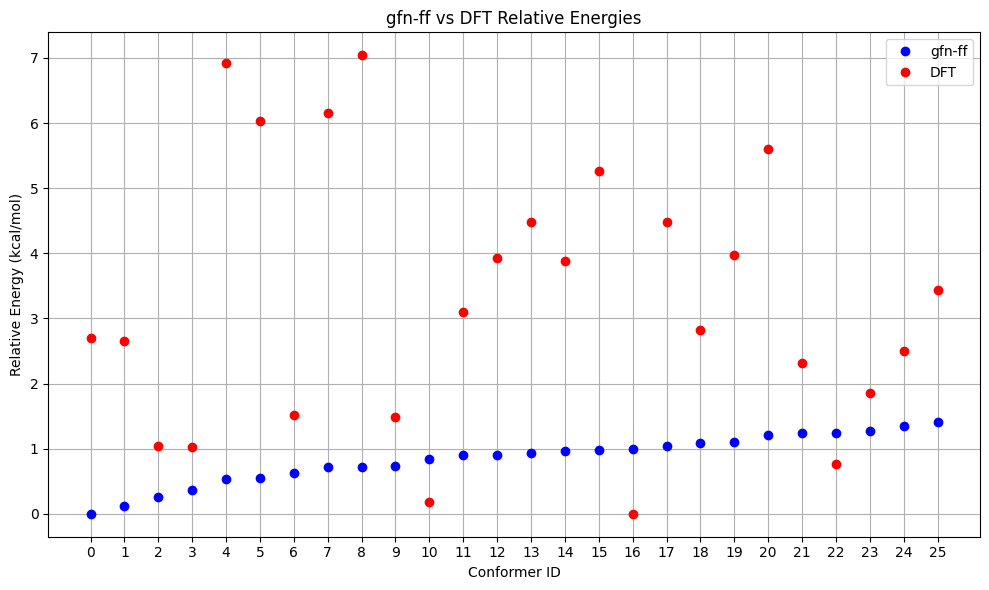


Energy Comparison Table:


ConfID,gfn-ff (kcal/mol),DFT (kcal/mol),Rank Change
0,0.00,2.69,↓11
1,0.12,2.65,↓9
2,0.25,1.04,↓2
3,0.37,1.02,-
4,0.54,6.92,↓20
5,0.54,6.03,↓17
6,0.62,1.51,-
7,0.72,6.15,↓16
8,0.72,7.04,↓17
9,0.74,1.48,↑4



Number of conformers below 1.0 kcal/mol (DFT): 3


ConfID,DFT Energy (Eh),ΔE (kcal/mol),Status
16,-629.907623,0.00,below
10,-629.907335,0.18,below
22,-629.906405,0.76,below
3,-629.906000,1.02,above
2,-629.905972,1.04,above
9,-629.905266,1.48,above
6,-629.905211,1.51,above
23,-629.904656,1.86,above
21,-629.903932,2.32,above
24,-629.903643,2.50,above


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [7]:

def confGenerator_GOAT(smiles: str, e_thresh: float, method: ForceField, working_dir: Path = Path("RUN"))-> tuple[list[tuple[float, int]], Mol, str]:
    """Generate and optimize conformers using ORCA GOAT"""
    
    # Generate initial 3D structure 
    smiles = re.sub(r'[^A-Za-z0-9]', '_', smiles)
    smiles_dir = working_dir / Path(f"{smiles}_{method}")
    smiles_dir.mkdir(exist_ok=True)

    xyz_file = smiles_dir / f"{smiles}.xyz"
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    xyz_block = Chem.MolToXYZBlock(mol)

    with open(xyz_file, 'w') as f:
        f.write(xyz_block)

    # > Set up the GOAT run

    # > Prepare the structures
    xyz_file = Path(xyz_file)
    mol_name = xyz_file.stem
    structure = Structure.from_xyz(xyz_file)
    
    # > Set up the calcualtor
    calc_dir = xyz_file.parent / mol_name
    calc_dir.mkdir(exist_ok=True)
    calc = Calculator(basename=mol_name, working_dir=calc_dir)
    calc.structure = structure
    # > Neutral molecule
    calc.structure.charge = 0
    # > Spin multiplicity of 1 (close-shell)
    calc.structure.multiplicity = 1
    
    calc.input.add_simple_keywords(
        method,
        Goat.GOAT
    )

    # > Use 8 cores for the calculation
    calc.input.ncores = 8

    # > Write the ORCA input file
    calc.write_input()
    
    # > Run the calculation
    calc.run()

    # The results of the conformer run can be found in the basename.finalensemble.xyz file
    result_file = calc_dir / f"{mol_name}.finalensemble.xyz"

    with open(result_file, 'r') as f:
        lines = f.readlines()

    i = 0
    conformer_energies = []
    mol.RemoveAllConformers()
    conf_counter = 0

    while i < len(lines):
        atom_count = int(lines[i].strip())
        energy_line = lines[i + 1].strip()
        atoms_block = lines[i + 2:i + 2 + atom_count]

        match = re.match(r"([-+]?[0-9]*\.?[0-9]+)", energy_line)
        energy = float(match.group(1)) * unit_conversion

        conf = Chem.Conformer(atom_count)
        for idx, line in enumerate(atoms_block):
            _, x, y, z = line.split()
            conf.SetAtomPosition(idx, (float(x), float(y), float(z)))

        conf_id = mol.AddConformer(conf, assignId=True)
        conformer_energies.append((energy, conf_id))

        i += 2 + atom_count
        conf_counter += 1
    print('Number of raw conformers:', len(conformer_energies))
    
    # Sort by energy and filter below energy threshold
    conformer_energies.sort()
    min_energy = conformer_energies[0][0]

    filtered_mol = copy.deepcopy(mol)
    filtered_mol.RemoveAllConformers()
    selected_conf_ids = []
    filtered_rel_e = []

    data = []
    for idx, (energy_value, conf_id) in enumerate(conformer_energies, start=1):
        delta_e = energy_value - min_energy
        status = "below" if delta_e <= e_thresh else "above"
        data.append({
            "ConfID": conf_id,
            "Energy (kcal/mol)": f"{energy_value:.2f}",
            "ΔE (kcal/mol)": f"{delta_e:.2f}",
            "Status": status
        })
        if delta_e <= e_thresh:
            conf = mol.GetConformer(conf_id)
            filtered_mol.AddConformer(conf)
            selected_conf_ids.append(conf_id)
            filtered_rel_e.append((delta_e, conf_id))

    df = pd.DataFrame(data)
    print(f"\nNumber of conformers below {e_thresh} kcal/mol ({method}): {len(selected_conf_ids)}")
    display(df.style.hide(axis="index"))
    return filtered_rel_e, filtered_mol, method

# > Run conformer generation with GOAT with 1.5 kcal/mol energy window and the GFN-FF
filtered_rel_e_goat, filtered_mol_goat, method_goat = confGenerator_GOAT(smiles=input_smiles, e_thresh=1.5, method=ForceField.GFN_FF, working_dir=working_dir)
# > Perform DFT single point energy calculations
filtered_mol_dft_goat, final_ids_goat = dft_calculations(smiles=input_smiles, e_thresh=1.0, functional= Dft.R2SCAN_3C, basis= None, rel_e=filtered_rel_e_goat, mol=filtered_mol_goat, method=method_goat, working_dir=working_dir)
# > Visualize the results
visualization(align=[0,1,2,3], highlight=1, mol=filtered_mol_dft_goat, ids=final_ids_goat)

## Summary

In this notebook, we demonstrated handling conformers. We utilized RDKit and GOAT to generate the conformers and re-ranked the conformers with DFT. Both can be done directly with OPI, streamlining common conformer workflows. The results were visualized within this notebook.  